In [1]:
#import necessary libraries
from IPython.core.display import display, HTML

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

In [2]:
#define important functions to be used throughout analysis
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
  
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    score = np.sqrt(mean_squared_log_error(y,y_pred))
    print("RSMLE = {0:.4f}".format(score))
    if show_figures:
        model.fit(X, y)
#         get_feature_importance(model, X.columns, n_features=25)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()
    
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed from {}".format(len(df_in)-len(df_out),col_name))
    return df_out

def count_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    out_sum = ((df_in[col_name] < (q1 - 1.5 * iqr)) | (df_in[col_name] > (q3 + 1.5 * iqr))).sum()
    print("{} outliers in {}".format(out_sum,col_name))
    return df_out

In [3]:
#import datasets
train = pd.read_csv("train.csv", delimiter=",", decimal=".")
test = pd.read_csv("test.csv", delimiter=",", decimal=".")

In [4]:
#create a train/test column to identify which dataset each row belongs to
train["train_or_test"] = "train"
test["train_or_test"] = "test"

In [5]:
#add target column in test
test["countRents"] = 0

In [6]:
#append train and test so that data cleaning will be performed once for both datasets
dataset = train.append(test, sort=False)

In [7]:
pd.options.display.max_columns = dataset.shape[1]

dataset.describe()

,id,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,pressure,precipAccumulation,ozone,countRents_prev_year,countRents
count,1.447200e+04,10747.000000,10747.000000,14441.000000,14441.000000,14445.000000,14441.000000,14428.000000,11346.000000,14427.000000,13437.000000,13906.000000,14417.000000,10746.000000,31.000000,7403.000000,14472.000000,14472.000000
mean,2.018453e+09,0.059376,0.073679,12.426741,11.707048,7.334021,0.735797,3.360549,6.642284,187.590698,0.591488,0.900115,9.394031,1014.654360,0.161613,335.418803,1196.934632,1136.733485
std,4.796206e+05,0.204857,0.170028,6.577660,7.375049,4.943962,0.163751,1.829870,3.947720,95.231239,0.311859,1.594720,2.098998,11.353184,0.200963,42.380998,1150.283598,1162.642796
min,2.018010e+09,0.000000,0.000000,-5.740000,-9.280000,-8.630000,0.230000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000,983.860000,0.005400,239.200000,1.000000,0.000000
25%,2.018053e+09,0.000000,0.000000,7.620000,5.880000,3.880000,0.630000,2.070000,3.402500,99.000000,0.350000,0.000000,9.791000,1007.082500,0.013700,305.500000,237.750000,168.000000
50%,2.018103e+09,0.000000,0.000000,11.710000,11.710000,7.500000,0.780000,3.070000,6.000000,211.000000,0.680000,0.000000,10.003000,1015.080000,0.046400,332.600000,881.000000,818.000000
75%,2.019033e+09,0.015700,0.040000,17.160000,17.170000,11.060000,0.870000,4.350000,9.560000,256.000000,0.850000,1.000000,10.003000,1022.690000,0.219500,359.100000,1779.000000,1686.000000
max,2.019083e+09,6.214500,0.980000,36.630000,37.540000,18.990000,1.000000,13.590000,21.160000,359.000000,1.000000,8.000000,16.093000,1044.180000,0.606400,485.400000,6423.000000,6188.000000


## Data Cleaning and Preparation

In [8]:
#check datatypes
dataset.dtypes

id                        int64
datetime                 object
summary                  object
icon                     object
precipIntensity         float64
precipProbability       float64
temperature             float64
apparentTemperature     float64
dewPoint                float64
humidity                float64
windSpeed               float64
windGust                float64
windBearing             float64
cloudCover              float64
uvIndex                 float64
visibility              float64
precipType               object
pressure                float64
precipAccumulation      float64
ozone                   float64
countRents_prev_year      int64
countRents                int64
train_or_test            object
dtype: object

In [9]:
#fix objects to categorical
categorical = ["summary", "icon", "precipType"]
dataset[categorical] = dataset[categorical].astype("category")

In [10]:
#extract information from date:
dataset["datetime"] = pd.to_datetime(dataset["datetime"])
dataset["month"] = dataset["datetime"].dt.month
dataset["weekday"] = dataset["datetime"].dt.weekday
dataset["weekend"] = np.where(dataset["weekday"]<5,0,1)
dataset["hour"] = dataset["datetime"].dt.hour

In [11]:
train.head()

,id,datetime,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,pressure,precipAccumulation,ozone,countRents_prev_year,countRents,train_or_test
0,2018010100,2018-01-01 00:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,7.18,4.39,3.82,0.79,4.29,7.80,250.0,0.83,0.0,10.003,NaN,997.33,NaN,NaN,932,754,train
1,2018010101,2018-01-01 01:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,6.93,4.38,3.55,0.79,3.73,6.43,251.0,0.40,0.0,10.003,NaN,998.29,NaN,NaN,892,630,train
2,2018010102,2018-01-01 02:00:00,Partly Cloudy,partly-cloudy-night,0.0,0.0,6.33,4.02,3.18,0.80,3.12,5.64,249.0,0.16,0.0,10.003,NaN,999.46,NaN,NaN,339,400,train
3,2018010103,2018-01-01 03:00:00,Clear,clear-night,0.0,0.0,6.07,3.66,2.88,0.80,3.20,5.69,241.0,0.08,0.0,10.003,NaN,999.55,NaN,NaN,282,249,train
4,2018010104,2018-01-01 04:00:00,Mostly Cloudy,partly-cloudy-night,0.0,0.0,5.88,3.54,2.84,0.81,3.03,5.69,233.0,0.65,0.0,10.003,NaN,999.65,NaN,NaN,185,168,train


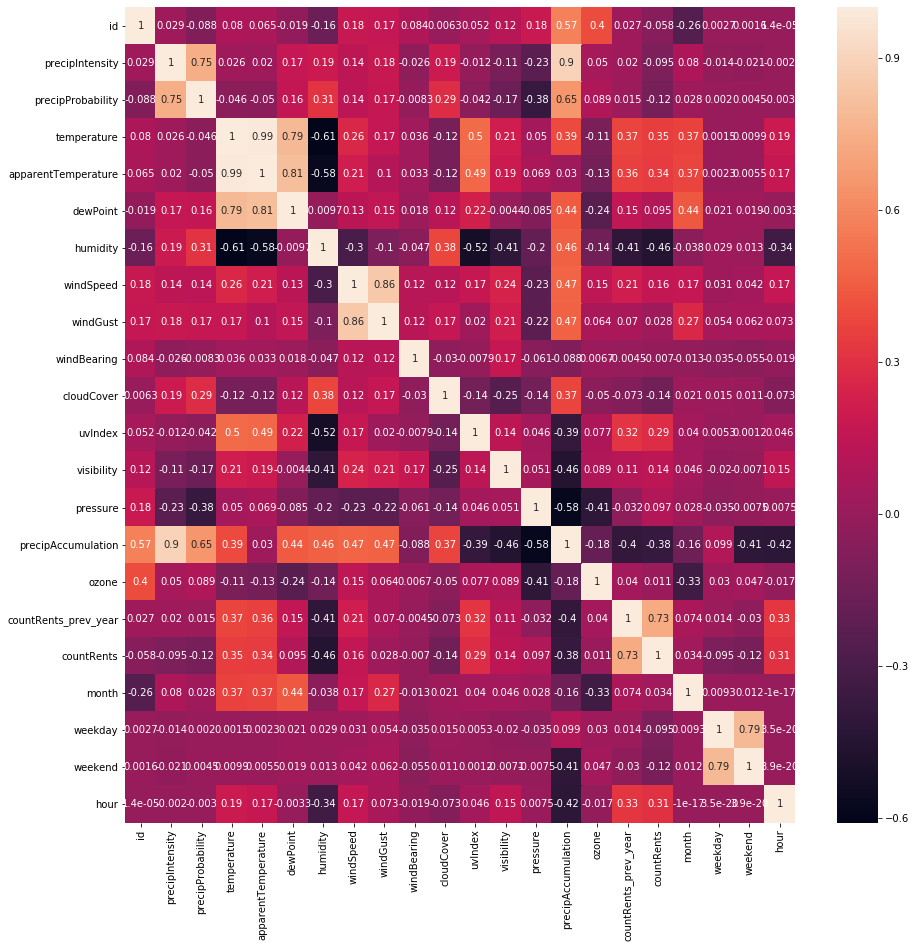

In [12]:
#generate correlation matrix to identify features to drop
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(15,15))
corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [13]:
#check for nulls
dataset.isnull().sum()

id                          0
datetime                    0
summary                    26
icon                       26
precipIntensity          3725
precipProbability        3725
temperature                31
apparentTemperature        31
dewPoint                   27
humidity                   31
windSpeed                  44
windGust                 3126
windBearing                45
cloudCover               1035
uvIndex                   566
visibility                 55
precipType               7131
pressure                 3726
precipAccumulation      14441
ozone                    7069
countRents_prev_year        0
countRents                  0
train_or_test               0
month                       0
weekday                     0
weekend                     0
hour                        0
dtype: int64

In [14]:
#using results of correlation and null check, identify varibles to drop
dataset.drop(["precipAccumulation", "humidity", "apparentTemperature", "dewPoint", "windGust", "precipIntensity"], axis=1, inplace=True)

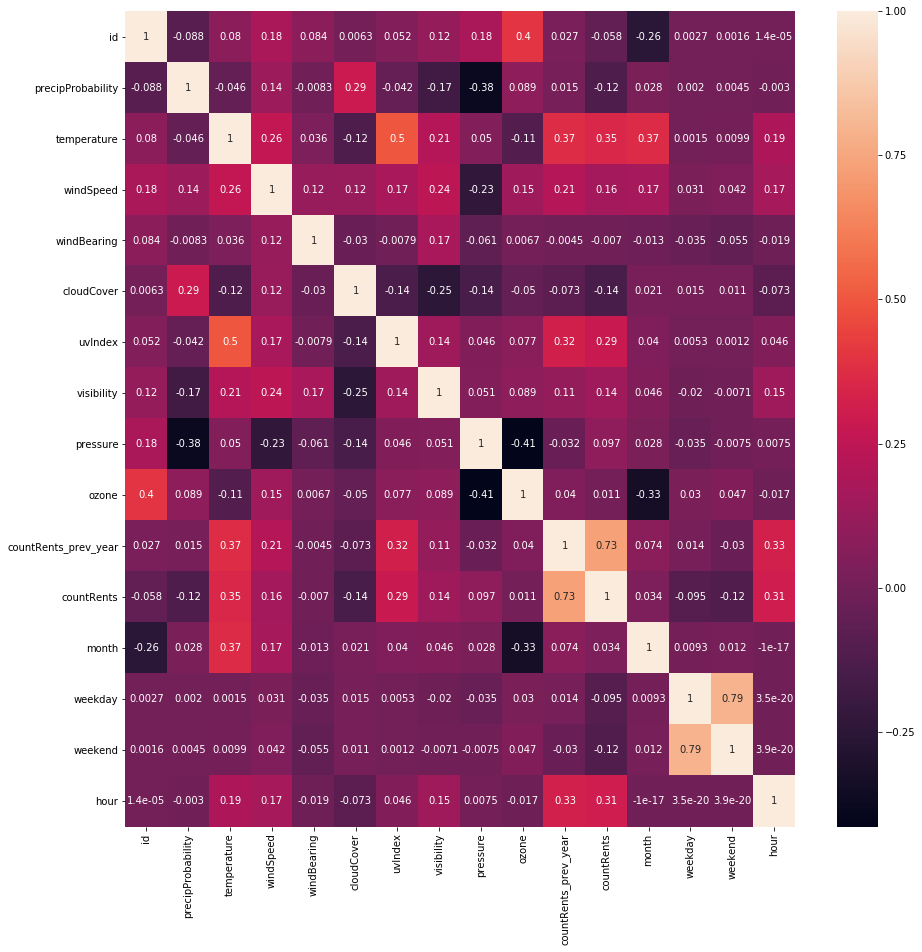

In [15]:
#doublecheck correlation matrix to ensure correlated variables have been removed
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(15,15))
corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [16]:
#handle nulls
dataset.isnull().sum()

id                         0
datetime                   0
summary                   26
icon                      26
precipProbability       3725
temperature               31
windSpeed                 44
windBearing               45
cloudCover              1035
uvIndex                  566
visibility                55
precipType              7131
pressure                3726
ozone                   7069
countRents_prev_year       0
countRents                 0
train_or_test              0
month                      0
weekday                    0
weekend                    0
hour                       0
dtype: int64

In [17]:
#approach to handle null values:
#variables that can be imputed:
# DELETE SUMMARY
# icon - delete empty rows
# precipProbability - groupby icon to get mean precip probability 
# temperature - groupby month to get mean temperature
# windSpeed - get average
# windBearing - get average
# cloudCover - groupby icon and get mean
# uvIndex - fill with mode (0)
# visibility - fill with mode (10.003) OR average
# precipType - fill with "no precip"
# pressure - groupby month to get mean pressure
# ozone - groupby month to get mean ozone

In [18]:
#get rid of nulls
dataset.drop(["summary"], axis=1, inplace=True)
dataset.dropna(subset=["icon"], inplace=True)

In [19]:
cols_to_impute_icon = ["precipProbability", "cloudCover"]

for i in cols_to_impute_icon:
    dataset[i] = dataset[i].fillna(dataset.groupby("icon")[i].transform('mean'))
    dataset[i] = dataset[i].fillna(dataset[i].mean())

In [20]:
dataset.head()

,id,datetime,icon,precipProbability,temperature,windSpeed,windBearing,cloudCover,uvIndex,visibility,precipType,pressure,ozone,countRents_prev_year,countRents,train_or_test,month,weekday,weekend,hour
0,2018010100,2018-01-01 00:00:00,partly-cloudy-night,0.0,7.18,4.29,250.0,0.83,0.0,10.003,NaN,997.33,NaN,932,754,train,1,0,0,0
1,2018010101,2018-01-01 01:00:00,partly-cloudy-night,0.0,6.93,3.73,251.0,0.40,0.0,10.003,NaN,998.29,NaN,892,630,train,1,0,0,1
2,2018010102,2018-01-01 02:00:00,partly-cloudy-night,0.0,6.33,3.12,249.0,0.16,0.0,10.003,NaN,999.46,NaN,339,400,train,1,0,0,2
3,2018010103,2018-01-01 03:00:00,clear-night,0.0,6.07,3.20,241.0,0.08,0.0,10.003,NaN,999.55,NaN,282,249,train,1,0,0,3
4,2018010104,2018-01-01 04:00:00,partly-cloudy-night,0.0,5.88,3.03,233.0,0.65,0.0,10.003,NaN,999.65,NaN,185,168,train,1,0,0,4


In [21]:
cols_to_impute_month = ["temperature", "pressure", "ozone"]

for i in cols_to_impute_month:
    dataset[i] = dataset[i].fillna(dataset.groupby("month")[i].transform('mean'))
    dataset[i] = dataset[i].fillna(dataset[i].mean())

In [22]:
for column in ['uvIndex', 'visibility']:
    dataset[column].fillna(dataset[column].mode()[0], inplace=True)

In [23]:
for column in ['windSpeed', 'windBearing']:
    dataset[column].fillna(dataset[column].mean(), inplace=True)

In [24]:
dataset['precipType'] = dataset['precipType'].cat.add_categories('no_precip')
dataset["precipType"].fillna("no_precip", inplace = True)

In [25]:
dataset.isnull().sum()

id                      0
datetime                0
icon                    0
precipProbability       0
temperature             0
windSpeed               0
windBearing             0
cloudCover              0
uvIndex                 0
visibility              0
precipType              0
pressure                0
ozone                   0
countRents_prev_year    0
countRents              0
train_or_test           0
month                   0
weekday                 0
weekend                 0
hour                    0
dtype: int64

In [26]:
dataset.drop(["datetime"], axis=1, inplace=True)

In [27]:
#handle outliers

#remove outliers only in the training data
outlier_free_dataset = dataset[dataset["train_or_test"]=="train"]

In [28]:
numerical_columns = dataset.columns.difference(categorical).tolist()
numerical_columns.remove("countRents")
numerical_columns.remove("id")
numerical_columns.remove("train_or_test")
numerical_columns.remove("hour")
numerical_columns.remove("month")
numerical_columns.remove("weekday")
numerical_columns.remove("weekend")

In [29]:
numerical_columns

['cloudCover',
 'countRents_prev_year',
 'ozone',
 'precipProbability',
 'pressure',
 'temperature',
 'uvIndex',
 'visibility',
 'windBearing',
 'windSpeed']

Analyzing outliers of column: precipProbability


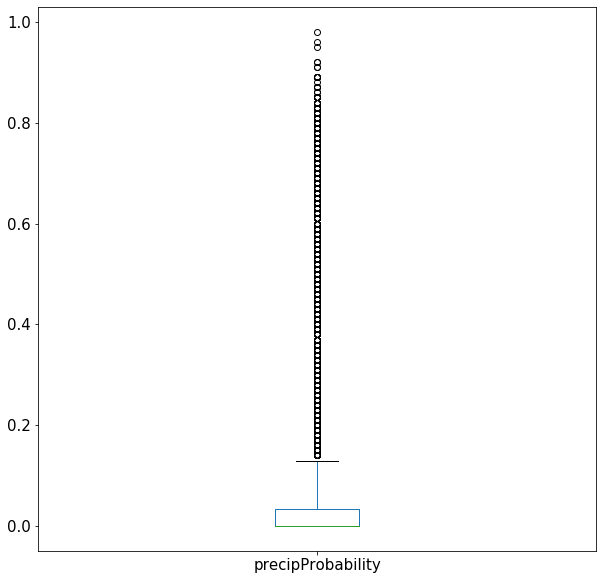

Analyzing outliers of column: temperature


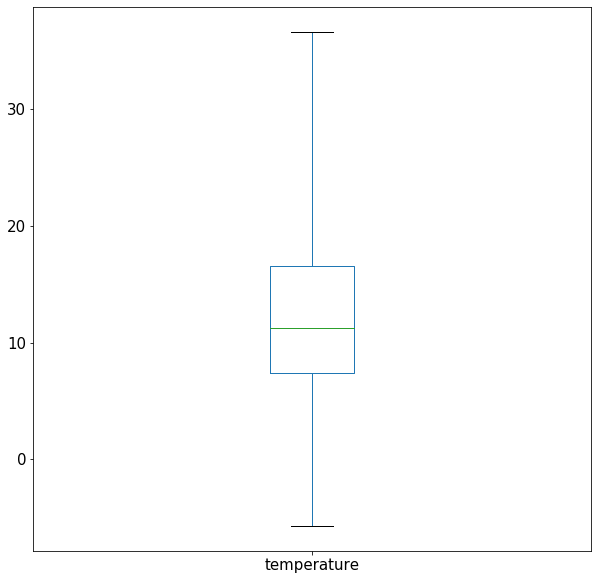

Analyzing outliers of column: windSpeed


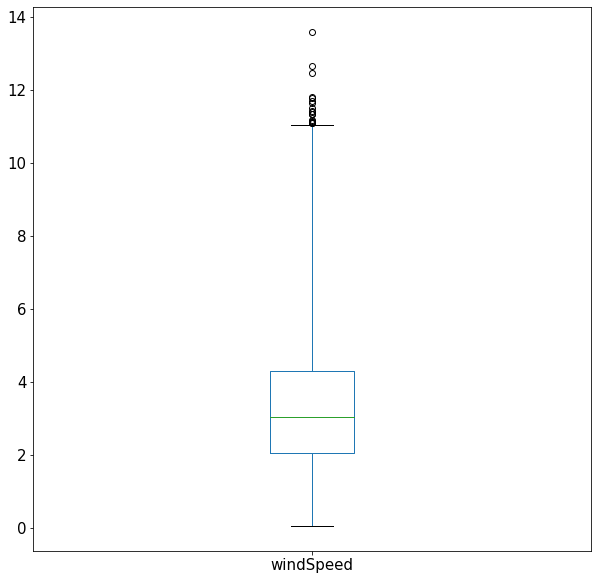

Analyzing outliers of column: windBearing


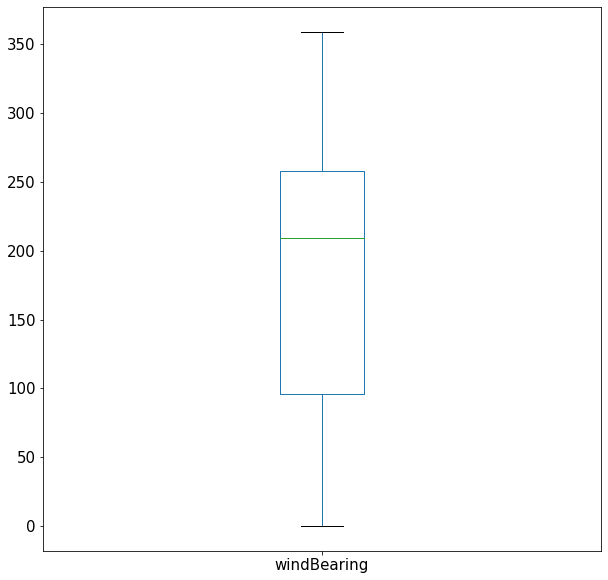

Analyzing outliers of column: cloudCover


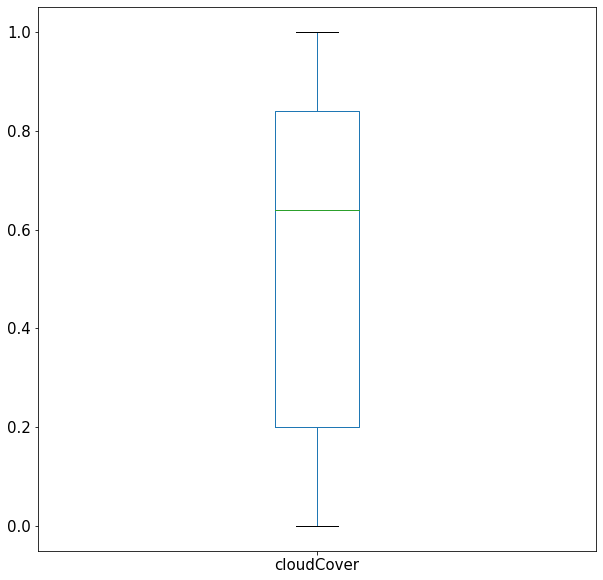

Analyzing outliers of column: uvIndex


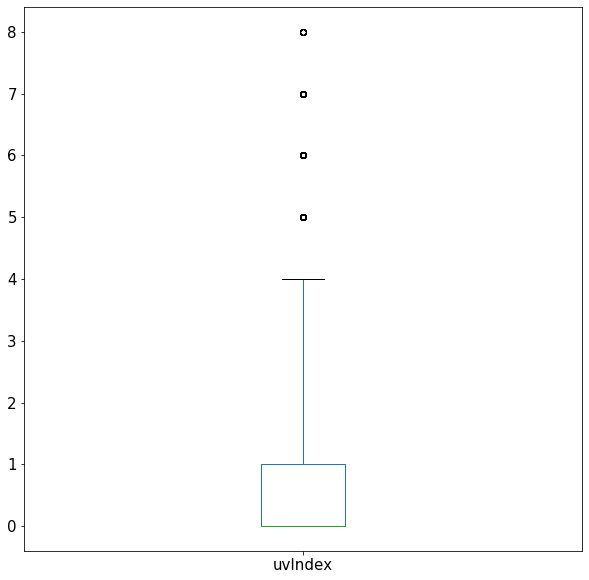

Analyzing outliers of column: visibility


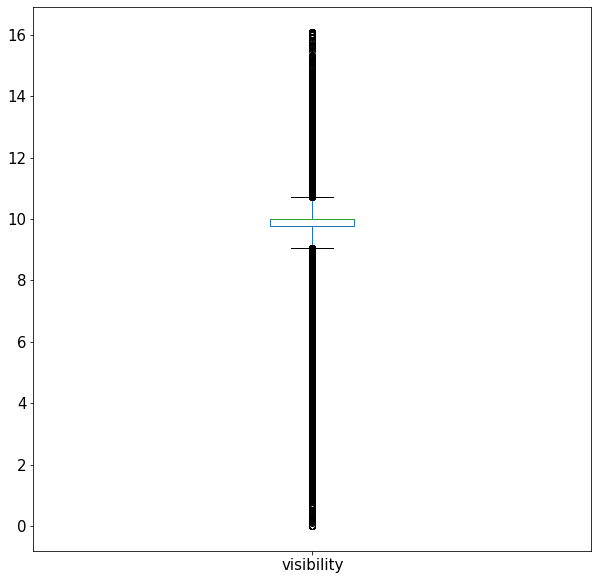

Analyzing outliers of column: pressure


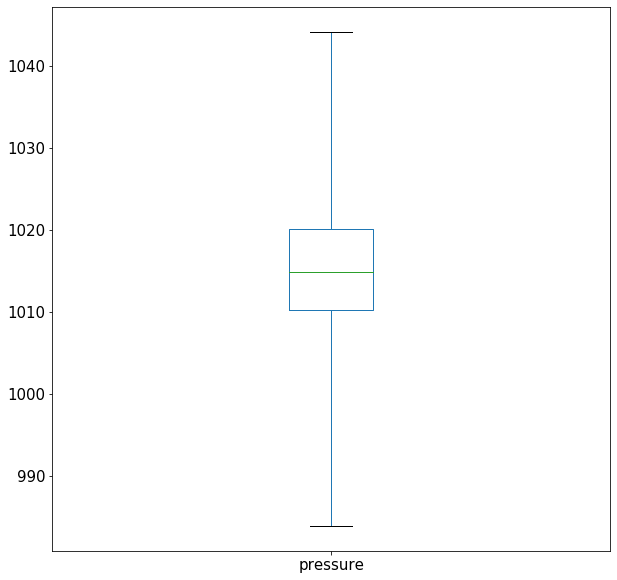

Analyzing outliers of column: ozone


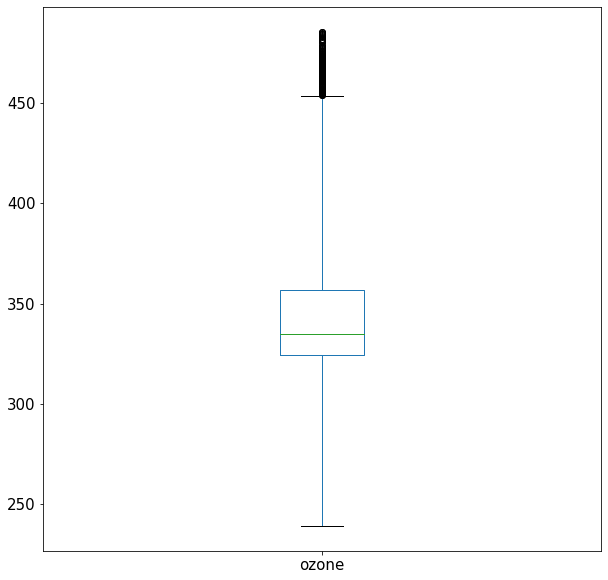

Analyzing outliers of column: countRents_prev_year


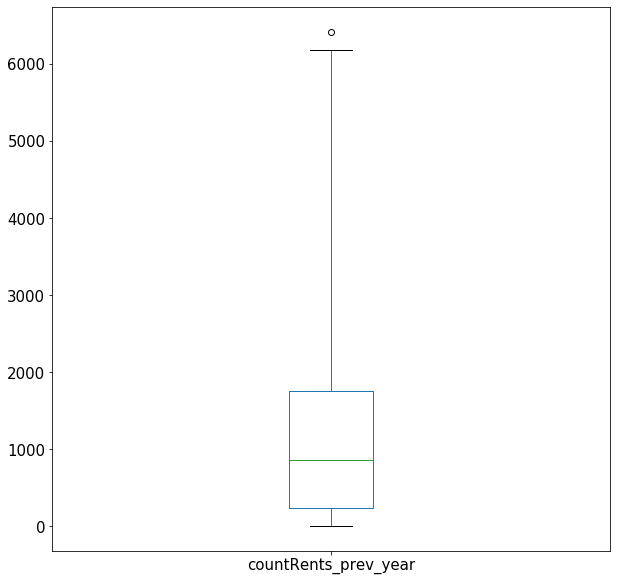

In [30]:
for (columnName, _) in outlier_free_dataset.iteritems():
    if columnName in numerical_columns: #numeric columns
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        outlier_free_dataset.boxplot([columnName], grid=False, fontsize=15, whis=3)
        plt.show()

In [31]:
for col in numerical_columns:
    count_outliers(outlier_free_dataset, col)

0 outliers in cloudCover
468 outliers in countRents_prev_year
899 outliers in ozone
1918 outliers in precipProbability
979 outliers in pressure
60 outliers in temperature
1968 outliers in uvIndex
3813 outliers in visibility
0 outliers in windBearing
335 outliers in windSpeed


In [32]:
outlier_cols = ["countRents_prev_year", "ozone", "precipProbability", "pressure", "temperature", "uvIndex", "visibility", "windSpeed"]

In [33]:
#impute fence high and low for outliers
for col in outlier_cols:
    q1 = outlier_free_dataset[col].quantile(0.25)
    q3 = outlier_free_dataset[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr 
    outlier_free_dataset[col] = outlier_free_dataset[col].map(lambda x:
                                                                           fence_low if x < fence_low else 
                                                                           (fence_high if x > fence_high else x))

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# append new outlier free dataset (train only) with the test set
cleaned_dataset = outlier_free_dataset.append(dataset[dataset["train_or_test"]=="test"], sort=False)

In [35]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = cleaned_dataset.columns[cleaned_dataset.dtypes=='category'].tolist()
numerical_cols = cleaned_dataset.columns[cleaned_dataset.dtypes!='category'].tolist()

numerical_cols.remove("id")
numerical_cols.remove("countRents")
numerical_cols.remove("train_or_test")
numerical_cols.remove("month")
numerical_cols.remove("weekday")
numerical_cols.remove("weekend")
numerical_cols.remove("hour")

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

In [36]:
numerical_cols

['precipProbability',
 'temperature',
 'windSpeed',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'visibility',
 'pressure',
 'ozone',
 'countRents_prev_year']

In [37]:
categorical_cols

['icon', 'precipType']

In [38]:
dummified_dataset = pd.concat([cleaned_dataset['id'].reset_index(drop=True),
                               cleaned_dataset['train_or_test'].reset_index(drop=True),
                              cleaned_dataset['month'].reset_index(drop=True),
                               cleaned_dataset['weekday'].reset_index(drop=True),
                               cleaned_dataset['weekend'].reset_index(drop=True),
                               cleaned_dataset['hour'].reset_index(drop=True),
                               pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(cleaned_dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(cleaned_dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                              cleaned_dataset['countRents'].reset_index(drop=True)], sort=True, axis=1)

In [39]:
dummified_dataset.head()

,id,train_or_test,month,weekday,weekend,hour,precipProbability,temperature,windSpeed,windBearing,cloudCover,...,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_sleet,icon_snow,icon_wind,precipType_no_precip,precipType_rain,precipType_sleet,precipType_snow,countRents
0,2018010100,train,1,0,0,0,0.0,0.333247,0.394249,0.696379,0.83,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,754
1,2018010101,train,1,0,0,1,0.0,0.326799,0.342301,0.699164,0.40,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,630
2,2018010102,train,1,0,0,2,0.0,0.311323,0.285714,0.693593,0.16,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,400
3,2018010103,train,1,0,0,3,0.0,0.304617,0.293135,0.671309,0.08,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,249
4,2018010104,train,1,0,0,4,0.0,0.299716,0.277365,0.649025,0.65,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,168


In [40]:
#split the dataset into train and test
train_cleaned = dummified_dataset[dummified_dataset['train_or_test'] == "train"]
test_cleaned = dummified_dataset[dummified_dataset['train_or_test'] == "test"]

In [41]:
train_cleaned = train_cleaned.drop(['train_or_test'],axis=1)

In [42]:
train_cleaned.head()

,id,month,weekday,weekend,hour,precipProbability,temperature,windSpeed,windBearing,cloudCover,uvIndex,...,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_sleet,icon_snow,icon_wind,precipType_no_precip,precipType_rain,precipType_sleet,precipType_snow,countRents
0,2018010100,1,0,0,0,0.0,0.333247,0.394249,0.696379,0.83,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,754
1,2018010101,1,0,0,1,0.0,0.326799,0.342301,0.699164,0.40,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,630
2,2018010102,1,0,0,2,0.0,0.311323,0.285714,0.693593,0.16,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,400
3,2018010103,1,0,0,3,0.0,0.304617,0.293135,0.671309,0.08,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,249
4,2018010104,1,0,0,4,0.0,0.299716,0.277365,0.649025,0.65,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,168


In [43]:
X_train = train_cleaned.loc[:, train_cleaned.columns != 'countRents']
y_train = train_cleaned['countRents']

In [44]:
test_cleaned = test_cleaned.drop(['train_or_test'],axis=1)

In [45]:
from sklearn.ensemble import RandomForestRegressor

#start with the basic hyperparameters to get a baseline model
rfc_model = RandomForestRegressor()

rfc_model.fit(X_train, y_train)

C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [46]:
rfc_fitted_model, score = train_model(X_train, y_train, rfc_model)

RSMLE = 0.4109


In [47]:
# X_test = test_cleaned.drop(["countRents"], axis=1)

In [48]:
# # Train the model using all the data
# final_model = rfc_model

# # Test prediction
# final_pred = final_model.predict(X_test)
# predictions = pd.DataFrame({'id':X_test['id'], 'countRents':final_pred})
# predictions.to_csv("countRents_predictions.csv", index=False)

In [51]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [52]:
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 40.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [54]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [55]:
rfc_model2 = RandomForestRegressor(n_estimators=1200, bootstrap = True, max_features = 'auto', min_samples_split = 2, min_samples_leaf = 2)

In [56]:
rfc_model2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [57]:
rfc_fitted_model_2, score = train_model(X_train, y_train, rfc_model2)

RSMLE = 0.3912


In [58]:
# Train the model using all the data
final_model = rfc_model2

# Test prediction
final_pred = final_model.predict(X_test)
predictions = pd.DataFrame({'id':test['id'], 'countRents':final_pred})
predictions.to_csv("countRents_predictions2.csv", index=False)